# 第6章　使用图像描述符检索和搜索图像

## 检测Harris角点

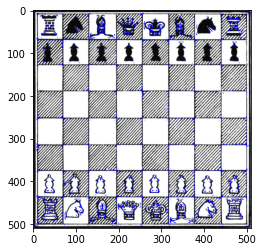

In [12]:
import cv2
from matplotlib import pyplot as plt
img = cv2.imread("images/chess_board.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dst = cv2.cornerHarris(gray, 2, 23 , 0.04)
img[dst > 0.01 * dst.max()] = [0, 0, 255]
plt.imshow(img)
plt.show()

## 检测DoG特征并提取SIFT描述符

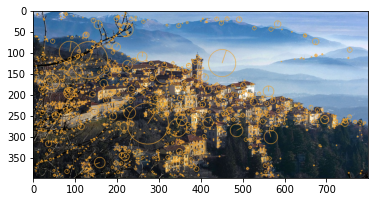

In [21]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread("images/varese.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift  = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray, None)

cv2.drawKeypoints(img, keypoints, img, (51, 163, 236), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## 检测快速Hessian特征并提取SURF描述符

In [ ]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread("images/varese.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

surf = cv2.xfeatures2d.SURF_create()
keypoints, descriptors = surf.detectAndCompute(gray, None)

cv2.drawKeypoints(img, keypoints, img, (51, 163, 236), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## 使用基于FAST特征和BRIEF描述符的ORB

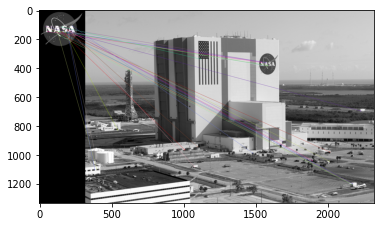

In [37]:
import cv2
from matplotlib import pyplot as plt

img0 = cv2.imread("images/nasa_logo.png", cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread("images/kennedy_space_center.jpg", cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
kp0, des0 = orb.detectAndCompute(img0, None)
kp1, des1 = orb.detectAndCompute(img1, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des0, des1)

matches = sorted(matches, key=lambda x: x.distance)

img_matches = cv2.drawMatches(img0, kp0, img1, kp1, matches[:25], img1, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img_matches)
plt.show()

## 使用K最近邻和比率检验过滤匹配

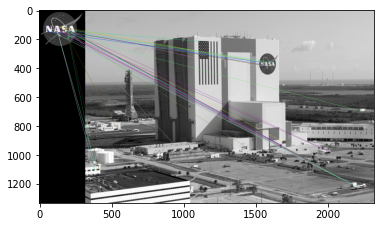

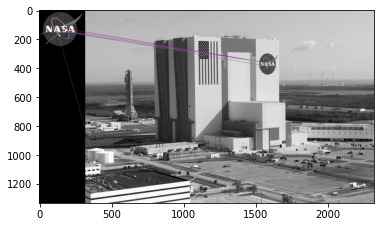

In [38]:
import cv2
from matplotlib import pyplot as plt

img0 = cv2.imread("images/nasa_logo.png", cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread("images/kennedy_space_center.jpg", cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
kp0, des0 = orb.detectAndCompute(img0, None)
kp1, des1 = orb.detectAndCompute(img1, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
parirs_of_matches = bf.knnMatch(des0, des1, k=2)

parirs_of_matches = sorted(parirs_of_matches, key=lambda x: x[0].distance)

img_parirs_of_matches = cv2.drawMatchesKnn(img0, kp0, img1, kp1, parirs_of_matches[:25], img1, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img_parirs_of_matches)
plt.show()

matches = [x[0] for x in  parirs_of_matches if len(x) > 1 and x[0].distance < 0.8 * x[1].distance]
img_matches = cv2.drawMatches(img0, kp0, img1, kp1, matches[:25], img1, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img_matches)
plt.show()

## 基于FLANN的匹配

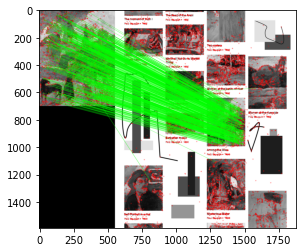

In [43]:
import numpy as np
import cv2
from matplotlib import  pyplot as plt

img0 = cv2.imread("images/gauguin_entre_les_lys.jpg", cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread("images/gauguin_paintings.png", cv2.IMREAD_GRAYSCALE)

sift = cv2.SIFT_create()
kp0, des0 = sift.detectAndCompute(img0, None)
kp1, des1 = sift.detectAndCompute(img1, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des0, des1, k=2)

mask_matches = [[0, 0] for i in range(len(matches))]

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        mask_matches[i] = [1, 0]
        
img_matches = cv2.drawMatchesKnn(img0, kp0, img1, kp1, matches, None, matchColor=(0, 255, 0), singlePointColor=(255, 0, 0), matchesMask=mask_matches, flags=0)

plt.imshow(img_matches)
plt.show()

## 基于FLANN进行单应性匹配

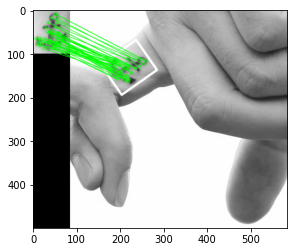

In [14]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

MIN_NUM_GOOD_MATCHES = 10

img0 = cv2.imread("images/query.png", cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread("images/anchor-man.png", cv2.IMREAD_GRAYSCALE)

sift = cv2.SIFT_create()
kp0, des0 = sift.detectAndCompute(img0, None)
kp1, des1 = sift.detectAndCompute(img1, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des0, des1, k=2)

good_matches =[]
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

if len(good_matches) >= MIN_NUM_GOOD_MATCHES:
    src_pts = np.float32([kp0[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp1[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    # ravel返回连续展平数组
    mask_matches = mask.ravel().tolist()
    h, w = img0.shape
    src_corners = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst_corners = cv2.perspectiveTransform(src_corners, M)
    dst_corners = dst_corners.astype(np.int32)
    
    num_corners = len(dst_corners)
    for i in range(num_corners):
        x0, y0 = dst_corners[i][0]
        if i== num_corners - 1:
            next_i = 0
        else:
            next_i = i + 1
        x1, y1 = dst_corners[next_i][0]
        cv2.line(img1, (x0, y0), (x1, y1), 255, 3, cv2.LINE_AA)
    # Draw the matches that passed the ratio test.
    img_matches = cv2.drawMatches(
        img0, kp0, img1, kp1, good_matches, None,
        matchColor=(0, 255, 0), singlePointColor=None,
        matchesMask=mask_matches, flags=2)
    plt.imshow(img_matches)
    plt.show()
else:
    print(f"Not enough matches good were found - {len(good_matches)}/{MIN_NUM_GOOD_MATCHES}")

## 将图像描述符保存到文件

In [15]:
import os
import numpy as np
import cv2

def create_descriptors(folder):
    feature_detector = cv2.SIFT_create()
    files = []
    for (dirpath, dirnames, filenames) in os.walk(folder):
        files.extend(filenames)
    for f in files:
        create_descriptor(folder, f, feature_detector)

def create_descriptor(folder, image_path, feature_detector):
    if not image_path.endswith('png'):
        print(f"skipping {image_path}")
    print(f"reading {image_path}")
    img = cv2.imread(os.path.join(folder, image_path), cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = feature_detector.detectAndCompute(img, None)
    descriptor_file = image_path.replace("png", "npy")
    np.save(os.path.join(folder, descriptor_file), descriptors)

folder = "data/tattoos"
create_descriptors(folder)

reading circus-woman.png
reading anchor-woman.png
reading anchor-man.png
reading lady-featherly.png
reading query.png
reading steel-arm.png


## 扫描匹配

In [18]:
import os
import numpy as np
import cv2

folder = "data/tattoos"
query = cv2.imread(os.path.join(folder, "query.png"), cv2.IMREAD_GRAYSCALE)

files = []
images = []
descriptors = []
for (dirpath, dirname, filenames) in os.walk(folder):
    files.extend(filenames)
    for f in files:
        if f.endswith("npy") and f!= "query.npy":
            descriptors.append(f)
print(descriptors)

sift = cv2.SIFT_create()
query_kp, query_ds = sift.detectAndCompute(query, None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

MIN_NUM_GOOD_MATCHES = 10

greatest_num_good_matches = 0
prime_suspect = None
print(">> init picture scan...")
for d in descriptors:
    print(f"-------------analyzing {d} for matches---------------")
    matches = flann.knnMatch(query_ds, np.load(os.path.join(folder, d)), k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    num_good_matches = len(good_matches)
    name = d.replace(".npy", "").upper()
    if num_good_matches  >= MIN_NUM_GOOD_MATCHES:
        print(f"{name} is a suspect! ({num_good_matches}  matches)")
        if num_good_matches > greatest_num_good_matches:
            greatest_num_good_matches = num_good_matches
            prime_suspect = name
    else:
        print(f"{name} is NOT a suspect. ({num_good_matches} matches)")

if prime_suspect is not None:
    print(F"Prime suspect so {prime_suspect}")
else:
    print("There is no suspect")

['anchor-woman.npy', 'anchor-man.npy', 'lady-featherly.npy', 'steel-arm.npy', 'circus-woman.npy']
>> init picture scan...
-------------analyzing anchor-woman.npy for matches---------------
ANCHOR-WOMAN is NOT a suspect. (2 matches)
-------------analyzing anchor-man.npy for matches---------------
ANCHOR-MAN is a suspect! (44  matches)
-------------analyzing lady-featherly.npy for matches---------------
LADY-FEATHERLY is NOT a suspect. (2 matches)
-------------analyzing steel-arm.npy for matches---------------
STEEL-ARM is NOT a suspect. (0 matches)
-------------analyzing circus-woman.npy for matches---------------
CIRCUS-WOMAN is NOT a suspect. (1 matches)
Prime suspect so ANCHOR-MAN
